In [9]:
# import libraries
import cdsapi
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 1. Get the raw data

The raw sea surface temperature (SST) and sea ice concentration (SIC) data will come from the `ERA5 monthly averaged data on single levels from 1940 to present` product. This data is located at the [Climate Data Store (CDS)](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download). There are two ways to download the data, described below. Note: You will need to make a CDS account to access this data (it's free).

### Option A: Download the raw data as a .zip file onto your system
You can fill out the options if you follow the link above with the following options:

* **Product type**: `Monthly averaged reanalysis`
* **Variable**: `Sea surface temperature` and `Sea-ice cover`
* **Year**: `1979-2023`
* **Month**: All
* **Time**: `00:00`
* **Geographical area**: `20 S to 90 N, -180 W to 180 E`
* **Data format**: `NetCDF4 (Experimental)`
* **Download format**: `Unarchived (not zipped if single file)` for easier access

Accept the `Terms of use`, and hit `Submit form`. The data will take some time to be pulled together, and then you have the option to download it onto your computer.

### Option B: Run the API get script below to pull the data into this folder directly from CDS

You will need an API access token associated with your account. If you run the script, and error will pop up to make the token if you do not already have one configured. Follow the directions from there. When you run this script (with your working API access token), it will download a .nc file directly into this folder). You will need to move the data into the appropriate folder (`data/raw/`) with the `mv` command using the following cell block. This code is also available as a `.py` file in the `scripts` folder.

### API get script

In [ ]:
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "sea_surface_temperature",
        "sea_ice_cover"
    ],
    "year": [
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [90, -180, 20, 180]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

In [ ]:
# Be sure that the raw data is in the appropriate folder with the edited file name
# 1. Adjust the name of the source file (if different than what is written
#        Option A: Replace the source file with data_0.nc if it was uploaded into this folder
#        Option B: Copy and paste the name of the .nc file from above
# 2. Edit the directory path of the desitination folder based on your home path
!mv d83063910d9a24d10af572d7e6efef8a.nc /glade/u/home/skygale/MLGEO2024_SeaIcePrediction/data/raw/raw_dic_sst_data.nc

## 2. Clean the raw data

To clean the raw data, which should be lcoated in the `raw/data/` folder, open the 'netcdf4' type file using 'xarray'. Be sure to adjust the directory path based on your system.

In [12]:
# Load dataset
ds = xr.open_dataset('/glade/u/home/skygale/MLGEO2024_SeaIcePrediction/data/raw/raw_sic_sst_data.nc')
ds

<xarray.Dataset> Size: 2GB
Dimensions:    (date: 549, latitude: 281, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * date       (date) int64 4kB 19790101 19790201 19790301 ... 20240801 20240901
  * latitude   (latitude) float64 2kB 90.0 89.75 89.5 89.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    expver     (date) <U4 9kB ...
Data variables:
    sst        (date, latitude, longitude) float32 889MB ...
    siconc     (date, latitude, longitude) float32 889MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-25T20:05 GRIB to CDM+CF via cfgrib-0.9.1...

In [10]:
# Extract the variables of interest from the data array
sic = ds['siconc']
sst = ds['sst']

# Check shapes before NaN removal
print('Before cleaning:', sic.shape, sst.shape)

# Flatten and remove NaNs
cleaned_sic = sic.dropna(dim='latitude', how='all')
cleaned_sic = cleaned_sic.dropna(dim='longitude', how='all')

cleaned_sst = sst.dropna(dim='latitude', how='all')
cleaned_sst = cleaned_sst.dropna(dim='longitude', how='all')

# Check shape after NaN removal
print('After cleaning: ', cleaned_sic.shape, cleaned_sst.shape)

# Put the clean data back into the array for saving
cleaned_ds = ds
cleaned_ds['siconc'] = cleaned_sic
cleaned_ds['sst'] = cleaned_sst

# Rename the 'siconc' variable to 'sic' for ease
cleaned_ds = cleaned_ds.rename({'siconc' : 'sic'})

Before cleaning: (549, 281, 1440) (549, 281, 1440)
After cleaning:  (549, 281, 1440) (549, 281, 1440)


In [11]:
# Save the clean data to the appropriate folder
clean_output = '/glade/u/home/skygale/MLGEO2024_SeaIcePrediction/data/clean/clean_sic_sst_data.nc'
cleaned_ds.to_netcdf(clean_output)
print(f'Saved combined dataset to {clean_output}')

Saved combined dataset to /glade/u/home/skygale/MLGEO2024_SeaIcePrediction/data/clean/clean_sic_sst_data.nc


## 3. Prepare the clean data to be AI-ready

We only want to keep September data from 50 N, so we will filter our data and then save it as an AI-ready dataset.

In [3]:
# Load dataset
clean_ds = xr.open_dataset('/glade/u/home/skygale/MLGEO2024_SeaIcePrediction/data/clean/clean_sic_sst_data.nc')
clean_ds

<xarray.Dataset> Size: 2GB
Dimensions:    (date: 549, latitude: 281, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * date       (date) int64 4kB 19790101 19790201 19790301 ... 20240801 20240901
  * latitude   (latitude) float64 2kB 90.0 89.75 89.5 89.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    expver     (date) <U4 9kB ...
Data variables:
    sst        (date, latitude, longitude) float32 889MB ...
    sic        (date, latitude, longitude) float32 889MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-25T20:05 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
# Get data north of 50N
north_ds = clean_ds.sel(latitude=clean_ds['latitude'] > 50)

# Convert 'date' from int64 to datetime
north_ds['date'] = pd.to_datetime(north_ds['date'].values, format='%Y%m%d')

# Get only September data
september_ds = north_ds.sel(date=north_ds['date'].dt.month == 9)

# Rename 'date' to 'time'
ai_ready_ds = september_ds.rename({'date': 'time'})

In [7]:
# Save the combined dataset to a new .nc file for ai-ready data
ai_ready_output = '/glade/u/home/skygale/MLGEO2024_SeaIcePrediction/data/ai_ready/ready_sic_sst_data.nc'
ai_ready_ds.to_netcdf(ai_ready_output)
print(f'Saved combined dataset to {ai_ready_output}')

Saved combined dataset to /glade/u/home/skygale/MLGEO2024_SeaIcePrediction/data/ai_ready/ready_sic_sst_data.nc


## 4. Perform some simple plotting analysis of the AI-ready data

In [8]:
data = xr.open_dataset('/glade/u/home/skygale/MLGEO2024_SeaIcePrediction/data/ai_ready/ready_sic_sst_data.nc')
data

<xarray.Dataset> Size: 85MB
Dimensions:    (time: 46, latitude: 160, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 368B 1979-09-01 1980-09-01 ... 2024-09-01
  * latitude   (latitude) float64 1kB 90.0 89.75 89.5 89.25 ... 50.75 50.5 50.25
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    expver     (time) <U4 736B ...
Data variables:
    sst        (time, latitude, longitude) float32 42MB ...
    sic        (time, latitude, longitude) float32 42MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-25T20:05 GRIB to CDM+CF via cfgrib-0.9.1...

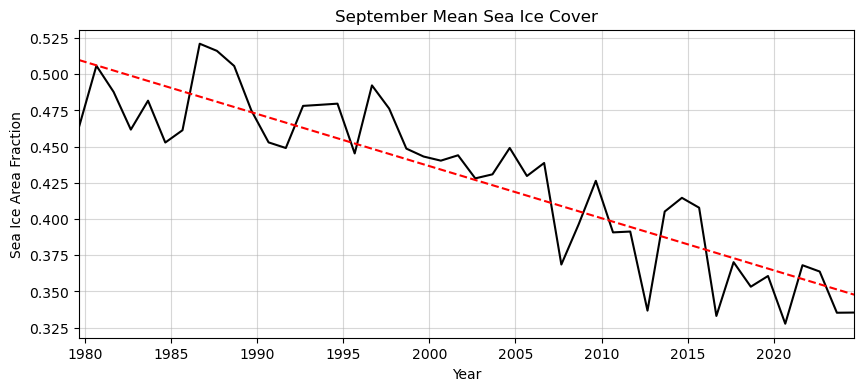

In [31]:
# Plot a timeseries of the change in sic over time with a trend
plt.figure(figsize=(10, 4))
plt.plot(data['time'], data['sic'].mean(dim=('latitude', 'longitude')), color='k')
time = np.arange(len(data['time']))
trend = np.polyfit(time, data['sic'].mean(dim=('latitude', 'longitude')), 1)
plt.plot(data['time'], trend[0]*time+trend[1], color='r', ls='--')
plt.xlabel('Year')
plt.ylabel('Sea Ice Area Fraction')
plt.title('September Mean Sea Ice Cover')
plt.grid(alpha=0.5)
plt.xlim(data['time'][0], data['time'][-1])
plt.show()

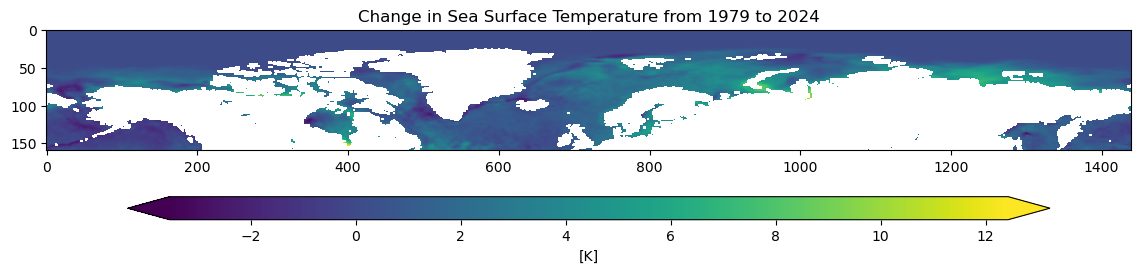

In [47]:
# Plot a spaital map of the change in sst over time
sst_trend = np.polyfit(time, data['sst'].mean(dim=('latitude', 'longitude')), 1)
detrended_sst = data['sst'] - (trend[0]*time[:, np.newaxis, np.newaxis])
plt.figure(figsize=(14, 12))
plt.imshow(detrended_sst[-1]-detrended_sst[0])
plt.colorbar(shrink=0.85, aspect=40, pad=0.05, extend='both', orientation='horizontal', label='[K]')
plt.title('Change in Sea Surface Temperature from 1979 to 2024')
plt.show()